<h1>Pix2Pix cGAN model</h1>

In [17]:
!pip install opencv-python torch
!pip install SimpleITK
import sys
!{sys.executable} -m pip install numpy pandas matplotlib seaborn scikit-learn opencv-python keras tensorflow jupyterlab notebook

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/332.0 MB 6.8 MB/s eta 0:00:49
   ---------------------------------------- 2.6/332.0 MB 6.7 MB/s eta 0:00:49
   ---------------------------------------- 3.9/332.0 MB 6.8 MB/s eta 0:00:49
    --------------------------------------- 5.5/332.0 MB 6.8 MB/s eta 0:00:49
    --------------------------------------- 6.8/332.0 MB 6.8 MB/s eta 0:00:48
    --------------------------------------- 8.1/332.0 MB 6.8 MB/s eta 0:00:48
   - -------------------------------------- 9.7/332.0 MB 6.8 MB/s eta 0:00:48
   - -------------------------------------- 11.0/332.0 MB 6.8 MB/s eta 0:00:48
   - -------------------------------------- 12.3/332.0 MB 6.8 MB/s eta 0:00:48
   - -------------------------------------- 13.9/332.0 MB 6.8 MB/s eta 0:00:47
 

In [1]:
import os, re, cv2, math, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

<h1>SynthRAD2025 pre-processing pipeline</h1>







## T1 → CT using the paired PNGs
### Preprocessing

In [2]:
def natural_key(p: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', p)]

def robust_norm(x, p_lo=0.5, p_hi=99.5, eps=1e-6):
    x = x.astype(np.float32)
    lo, hi = np.percentile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    mu, sd = x.mean(), x.std() + eps
    x = (x - mu) / sd
    x = np.tanh(x)  # squash to [-1, 1]
    return x

class PairedCTT2Loader(keras.utils.Sequence):
    """
    Directory layout (paired by identical sorted order within each patient):
      data/CT/PNG/Patient_001/*.png
      data/T2-MRI/PNG/Patient_001/*.png
    """
    def __init__(self, ct_root, t2_root, image_size=(256, 256), batch_size=8, shuffle=True, aug=True):
        self.ct_root = Path(ct_root)
        self.t2_root = Path(t2_root)
        self.H, self.W = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug

        # patients present in both dirs
        pats_ct = {p.name for p in self.ct_root.iterdir() if p.is_dir()}
        pats_t2 = {p.name for p in self.t2_root.iterdir() if p.is_dir()}
        self.patients = sorted(list(pats_ct & pats_t2))

        # build slice pairs
        self.pairs = []
        dropped = 0
        for pid in self.patients:
            cdir = self.ct_root / pid
            tdir = self.t2_root / pid
            ct_slices = sorted([f for f in os.listdir(cdir) if f.lower().endswith(('.png','.jpg','.jpeg'))], key=natural_key)
            t2_slices = sorted([f for f in os.listdir(tdir) if f.lower().endswith(('.png','.jpg','.jpeg'))], key=natural_key)
            n = min(len(ct_slices), len(t2_slices))
            for i in range(n):
                self.pairs.append((str(cdir/ct_slices[i]), str(tdir/t2_slices[i])))
            dropped += abs(len(ct_slices)-len(t2_slices))
        if dropped:
            print(f"[Loader] Warning: dropped {dropped} unmatched slices across patients.")

        self.indices = np.arange(len(self.pairs))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.pairs) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        idx = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_t2, Y_ct = [], []
        for i in idx:
            ct_path, t2_path = self.pairs[i]
            ct = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
            t2 = cv2.imread(t2_path, cv2.IMREAD_GRAYSCALE)
            if ct is None or t2 is None:
                continue  # skip broken files

            # Resize (cv2 expects (W,H))
            interp_ct = cv2.INTER_AREA if (ct.shape[0] >= self.H or ct.shape[1] >= self.W) else cv2.INTER_CUBIC
            interp_t2 = cv2.INTER_AREA if (t2.shape[0] >= self.H or t2.shape[1] >= self.W) else cv2.INTER_CUBIC
            ct = cv2.resize(ct, (self.W, self.H), interpolation=interp_ct)
            t2 = cv2.resize(t2, (self.W, self.H), interpolation=interp_t2)

            # Robust normalization → [-1, 1]
            ct = robust_norm(ct)
            t2 = robust_norm(t2)

            # simple paired flips/rotate
            if self.aug:
                if np.random.rand() < 0.5:
                    ct = np.flip(ct, axis=1); t2 = np.flip(t2, axis=1)
                if np.random.rand() < 0.2:
                    ct = np.flip(ct, axis=0); t2 = np.flip(t2, axis=0)
                if np.random.rand() < 0.3:
                    ang = np.random.uniform(-7, 7)
                    sc  = 1.0 + np.random.uniform(-0.05, 0.05)
                    M = cv2.getRotationMatrix2D((self.W/2, self.H/2), ang, sc)
                    ct = cv2.warpAffine(ct, M, (self.W, self.H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
                    t2 = cv2.warpAffine(t2, M, (self.W, self.H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

            # add channel dim
            X_t2.append(t2[..., None].astype(np.float32))
            Y_ct.append(ct[..., None].astype(np.float32))

        X_t2 = np.stack(X_t2, axis=0)
        Y_ct = np.stack(Y_ct, axis=0)
        return X_t2, Y_ct

## PIX2PIX Model

In [3]:
def down_block(filters, apply_batchnorm=True):
    block = keras.Sequential()
    block.add(layers.Conv2D(filters, 4, strides=2, padding="same", use_bias=not apply_batchnorm))
    if apply_batchnorm:
        block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    return block

def up_block(filters, apply_dropout=False):
    block = keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, 4, strides=2, padding="same", use_bias=False))
    block.add(layers.BatchNormalization())
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    block.add(layers.ReLU())
    return block

def build_generator(image_size=(256,256), in_channels=1, out_channels=1):
    inputs = layers.Input(shape=(image_size[0], image_size[1], in_channels))
    downs = [
        down_block(64,  apply_batchnorm=False),
        down_block(128),
        down_block(256),
        down_block(512),
        down_block(512),
        down_block(512),
        down_block(512),
        down_block(512),
    ]
    x = inputs
    skips = []
    for d in downs:
        x = d(x); skips.append(x)
    skips = skips[:-1][::-1]

    ups = [
        up_block(512, True),
        up_block(512, True),
        up_block(512, True),
        up_block(512, False),
        up_block(256, False),
        up_block(128, False),
        up_block(64,  False),
    ]
    for up, skip in zip(ups, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    out = layers.Conv2DTranspose(out_channels, 4, strides=2, padding="same", activation="tanh")(x)
    return keras.Model(inputs, out, name="generator")

def build_discriminator(image_size=(256,256), in_channels=1, cond_channels=1):
    inp = layers.Input(shape=(image_size[0], image_size[1], in_channels))   # condition (T2)
    tar = layers.Input(shape=(image_size[0], image_size[1], cond_channels)) # target (CT)
    x = layers.Concatenate()([inp, tar])
    def dlayer(x, f, s=2, bn=True):
        x = layers.Conv2D(f, 4, strides=s, padding="same", use_bias=not bn)(x)
        if bn: x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        return x
    x = dlayer(x, 64,  bn=False)
    x = dlayer(x, 128)
    x = dlayer(x, 256)
    x = dlayer(x, 512, s=1)
    out = layers.Conv2D(1, 4, strides=1, padding="same")(x)  # logits
    return keras.Model([inp, tar], out, name="discriminator")

class Pix2Pix(keras.Model):
    def __init__(self, generator, discriminator, l1_lambda=100.0):
        super().__init__()
        self.gen = generator
        self.disc = discriminator
        self.l1_lambda = l1_lambda
        self.bce = keras.losses.BinaryCrossentropy(from_logits=True)

        self.m_gen = keras.metrics.Mean(name="gen_total")
        self.m_gan = keras.metrics.Mean(name="gen_gan")
        self.m_l1  = keras.metrics.Mean(name="gen_l1")
        self.m_disc= keras.metrics.Mean(name="disc")
        self.m_psnr= keras.metrics.Mean(name="psnr")
        self.m_ssim= keras.metrics.Mean(name="ssim")

    def compile(self, gen_opt, disc_opt, **kwargs):
        super().compile(**kwargs)
        self.gen_opt, self.disc_opt = gen_opt, disc_opt

    def train_step(self, data):
        x, y = data  # both in [-1,1]
        with tf.GradientTape(persistent=True) as tape:
            fake = self.gen(x, training=True)
            d_real = self.disc([x, y], training=True)
            d_fake = self.disc([x, fake], training=True)

            # losses
            gen_gan = self.bce(tf.ones_like(d_fake), d_fake)
            gen_l1  = tf.reduce_mean(tf.abs(y - fake))
            gen_tot = gen_gan + self.l1_lambda * gen_l1

            d_real_loss = self.bce(tf.ones_like(d_real), d_real)
            d_fake_loss = self.bce(tf.zeros_like(d_fake), d_fake)
            d_loss = 0.5 * (d_real_loss + d_fake_loss)

        g_grads = tape.gradient(gen_tot, self.gen.trainable_variables)
        d_grads = tape.gradient(d_loss, self.disc.trainable_variables)
        del tape
        self.gen_opt.apply_gradients(zip(g_grads, self.gen.trainable_variables))
        self.disc_opt.apply_gradients(zip(d_grads, self.disc.trainable_variables))

        # metrics
        y01, f01 = (y+1)/2, (fake+1)/2
        psnr = tf.reduce_mean(tf.image.psnr(y01, f01, max_val=1.0))
        ssim = tf.reduce_mean(tf.image.ssim(y01, f01, max_val=1.0))

        self.m_gen.update_state(gen_tot); self.m_gan.update_state(gen_gan)
        self.m_l1.update_state(gen_l1);   self.m_disc.update_state(d_loss)
        self.m_psnr.update_state(psnr);   self.m_ssim.update_state(ssim)

        return {"gen": self.m_gen.result(), "gen_gan": self.m_gan.result(),
                "gen_l1": self.m_l1.result(), "disc": self.m_disc.result(),
                "psnr": self.m_psnr.result(), "ssim": self.m_ssim.result()}

    def test_step(self, data):
        x, y = data
        fake = self.gen(x, training=False)
        d_real = self.disc([x, y], training=False)
        d_fake = self.disc([x, fake], training=False)

        gen_gan = self.bce(tf.ones_like(d_fake), d_fake)
        gen_l1  = tf.reduce_mean(tf.abs(y - fake))
        gen_tot = gen_gan + self.l1_lambda * gen_l1
        d_loss  = 0.5*(self.bce(tf.ones_like(d_real), d_real) + self.bce(tf.zeros_like(d_fake), d_fake))

        y01, f01 = (y+1)/2, (fake+1)/2
        psnr = tf.reduce_mean(tf.image.psnr(y01, f01, max_val=1.0))
        ssim = tf.reduce_mean(tf.image.ssim(y01, f01, max_val=1.0))

        return {"gen": gen_tot, "gen_gan": gen_gan, "gen_l1": gen_l1,
                "disc": d_loss, "psnr": psnr, "ssim": ssim}

## Trainning and Evaluation

In [4]:
ct_folder = "data/CT/PNG"
t1_folder = "data/T1-MRI/PNG"

# smaller size for a quick demo run
IMAGE_SIZE = (256, 256)

BATCH = 8

train_loader = PairedCTT2Loader(ct_folder, t1_folder, image_size=IMAGE_SIZE, batch_size=BATCH, shuffle=True, aug=True)
val_loader   = PairedCTT2Loader(ct_folder, t1_folder, image_size=IMAGE_SIZE, batch_size=BATCH, shuffle=False, aug=False)

gen  = build_generator(image_size=IMAGE_SIZE, in_channels=1, out_channels=1)
disc = build_discriminator(image_size=IMAGE_SIZE, in_channels=1, cond_channels=1)

model = Pix2Pix(gen, disc, l1_lambda=100.0)
model.compile(
    gen_opt = keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999),
    disc_opt= keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999),
)

gen.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      1,088 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,419,777 (207.59 MB)

 Trainable params: 54,408,897 (207.55 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [5]:
history = model.fit(
    train_loader,
    validation_data=val_loader,
    # epochs=100, -> Run for better synthetics image
    epochs=50,
)


Epoch 1/50


C:\Users\duymi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - disc: 0.7332 - gen: 35.8427 - gen_gan: 0.8606 - gen_l1: 0.3498 - psnr: 12.7292 - ssim: 0.2571 - val_disc: 0.6823 - val_gen: 54.3967 - val_gen_gan: 0.7635 - val_gen_l1: 0.5363 - val_psnr: 10.8534 - val_ssim: 0.4693
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - disc: 0.6165 - gen: 29.6864 - gen_gan: 0.9524 - gen_l1: 0.2873 - psnr: 13.7261 - ssim: 0.3810 - val_disc: 0.6613 - val_gen: 46.0351 - val_gen_gan: 1.1461 - val_gen_l1: 0.4489 - val_psnr: 12.3072 - val_ssim: 0.4649
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - disc: 0.4875 - gen: 28.5072 - gen_gan: 1.2599 - gen_l1: 0.2725 - psnr: 13.9157 - ssim: 0.3998 - val_disc: 0.6827 - val_gen: 41.8224 - val_gen_gan: 0.7789 - val_gen_l1: 0.4104 - val_psnr: 12.6894 - val_ssim: 0.4691
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - disc: 0.3026 - gen: 27.5365 - gen_gan: 1.6979 - gen_l1: 0.2584 - psnr: 14.1586 - ssim: 0.4100 - val_disc: 0.6621 - val_gen: 37.4031 - val_gen_gan: 0.7069 - val_g

Synth batch range: 0.016255766 0.9997568


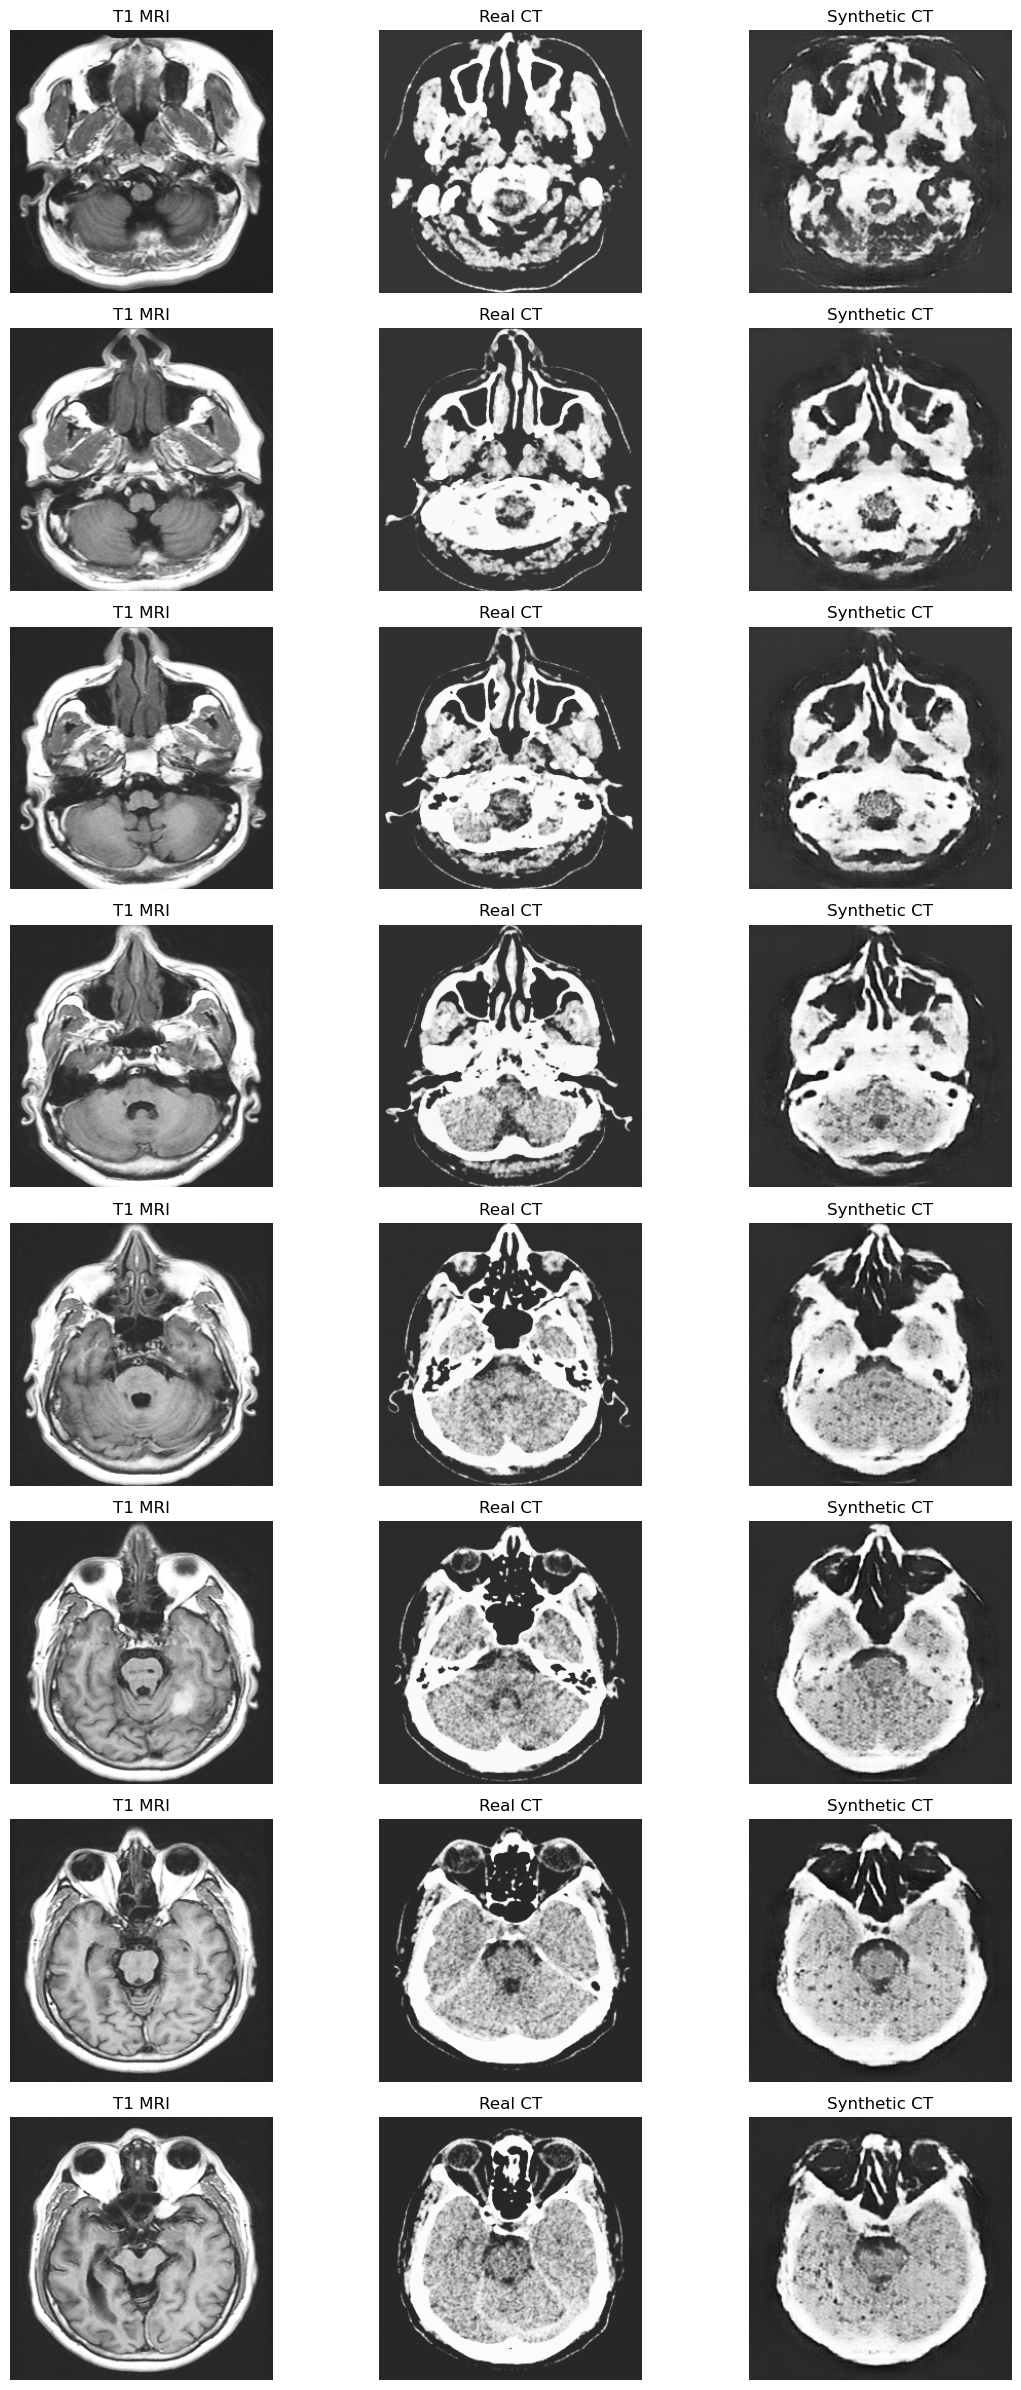

In [6]:
X_t2, Y_ct = val_loader[0]  
pred_ct = gen.predict(X_t2, verbose=0)

def to01(a):  
    return np.clip((a + 1.0)/2.0, 0.0, 1.0)

Xv, Yv, Pv = to01(X_t2), to01(Y_ct), to01(pred_ct)
print("Synth batch range:", Pv.min(), Pv.max())


n_show = min(10, Xv.shape[0])
plt.figure(figsize=(12, 3*n_show))
for i in range(n_show):
    t2 = Xv[i, ..., 0]; ct = Yv[i, ..., 0]; sy = Pv[i, ..., 0]
    plt.subplot(n_show, 3, 3*i+1); plt.imshow(t2, cmap='gray', vmin=0, vmax=1); plt.axis('off'); plt.title("T1 MRI")
    plt.subplot(n_show, 3, 3*i+2); plt.imshow(ct, cmap='gray', vmin=0, vmax=1); plt.axis('off'); plt.title("Real CT")
    plt.subplot(n_show, 3, 3*i+3); plt.imshow(sy, cmap='gray', vmin=0, vmax=1); plt.axis('off'); plt.title("Synthetic CT")
plt.tight_layout() 
plt.show()